# Forecast with Amazon SageMaker DeepAR 3 (Synthetic data)

Often times, you encounter more complex types of data when building a time-series model. This notebook demonstrates how to prepare a synthetic dataset of time series for training DeepAR and how to use the trained model for inference.

DeepAR is an algorithm introduced in 2017. It’s quite complex and I won’t go into details here. Let’s just say that unlike other techniques that train a different model for each time-series, DeepAR builds a single model for all time-series and tries to identify similarities across them. Intuitively, this sounds like a good idea for temperature time-series as we could expect them to exhibit similar patterns year after year.

In [1]:
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
import matplotlib.pyplot as plt                   # For charts and visualizations
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sys                                        # For writing outputs to notebook
import math                                       # For ceiling function
import json                                       # For parsing hosting outputs
import os                                         # For manipulating filepath names
import boto3
import botocore
from botocore.exceptions import ClientError

import csv
import io
import re
import s3fs


import sagemaker                                 
from sagemaker.predictor import csv_serializer 
from sagemaker.predictor import json_deserializer
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role

### 1. Preparation (Specifying Sagemaker roles)

In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()                     
prefix = 'deepar-synthetic'
region = boto3.Session().region_name
role = 'arn:aws:iam::570447867175:role/SageMakerNotebookRole' # pass your IAM role name

print('Sagemaker session :', sagemaker_session)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x0000025F057E1908>
S3 bucket : sagemaker-us-west-2-570447867175
Prefix : deepar-synthetic
Region selected : us-west-2
IAM role : arn:aws:iam::570447867175:role/SageMakerNotebookRole


In [4]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(region, 'forecasting-deepar')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


### 2. Load Data

##### In this toy example we want to train a model that can predict the next 48 points of syntheticly generated time series. The time series that we use have hourly granularity

In [5]:
freq = 'H'
prediction_length = 48

We also need to configure the so-called context_length, which determines how much context of the time series the model should take into account when making the prediction, i.e. how many previous points to look at. A typical value to start with is around the same size as the prediction_length. In our example we will use a longer context_length of 72. Note that in addition to the context_length the model also takes into account the values of the time series at typical seasonal windows e.g. for hourly data the model will look at the value of the series 24h ago, one week ago one month ago etc. So it is not necessary to make the context_length span an entire month if you expect monthly seasonalities in your hourly data.

In [6]:
context_length = 72

For this notebook, we will generate 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. In our dummy example, all time series start at the same time point t0. When preparing your data, it is important to use the correct start point for each time series, because the model uses the time-point as a frame of reference, which enables it to learn e.g. that weekdays behave differently from weekends.

In [7]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

Each time series will be a noisy sine wave with a random level

In [9]:
time_series = []
for k in range(num_ts):
    level = 10 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.date_range(start=t0, freq=freq, periods=data_length)
    time_series.append(pd.Series(data=data, index=index))

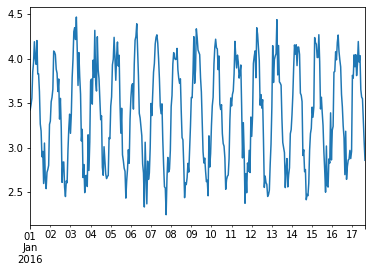

In [13]:
time_series[0].plot()
plt.show()

##### Often one is interested in tuning or evaluating the model by looking at error metrics on a validation set. 
For other machine learning tasks such as classification, one typically does this by randomly separating examples into train/test sets. For forecasting it is important to do this train/test split in time rather than by series.

In this example, we will leave out the last section of each of the time series we just generated and use only the first part as training data. Here we will predict 48 data points, therefore we take out the trailing 48 points from each time series to define the training set. The test set contains the full range of each time series.

In [14]:
time_series_training = []
for ts in time_series:
    time_series_training.append(ts[:-prediction_length])

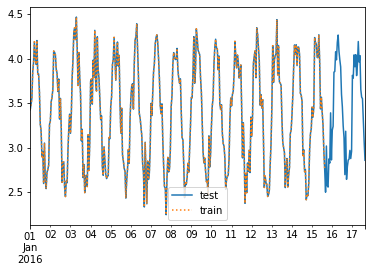

In [15]:
time_series[0].plot(label='test')
time_series_training[0].plot(label='train', ls=':')
plt.legend()
plt.show()

In [16]:
# Set path
s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

print('Data path :', s3_data_path)
print('Output path :', s3_output_path)

Data path : sagemaker-us-west-2-570447867175/deepar-synthetic/data
Output path : sagemaker-us-west-2-570447867175/deepar-synthetic/output


### 3. Data Pre-processing

The following utility functions convert pandas.Series objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3.

In [17]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [18]:
encoding = "utf-8"
s3filesystem = s3fs.S3FileSystem()

with s3filesystem.open(s3_data_path + "/train/train.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

with s3filesystem.open(s3_data_path + "/test/test.json", 'wb') as fp:
    for ts in time_series:
        fp.write(series_to_jsonline(ts).encode(encoding))
        fp.write('\n'.encode(encoding))

### 4. Start Training

In [19]:
# 1. Create 'Estimator' to start training job
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    base_job_name='deepar-synthetic',
    output_path="s3://" + s3_output_path
)

In [20]:
# 2. Set Hyperparameter 
### We are NOT going to do hyperparam optimization for time-saving purpose ###
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [21]:
estimator.set_hyperparameters(**hyperparameters)

We are ready to launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last prediction_length points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

In [22]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

In [23]:
estimator.fit(inputs=data_channels)

2020-07-22 03:27:11 Starting - Starting the training job...
2020-07-22 03:27:14 Starting - Launching requested ML instances......
2020-07-22 03:28:25 Starting - Preparing the instances for training......
2020-07-22 03:29:40 Downloading - Downloading input data...
2020-07-22 03:30:05 Training - Downloading the training image...
2020-07-22 03:30:36 Training - Training image download completed. Training in progress.Arguments: train
[07/22/2020 03:30:38 INFO 140662884079424] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u

### 5. Deploy the model

In [24]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.p2.xlarge',
    deployment_image=image_name,
    role=role
)

---------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings. 
This function is from AWS official blog.

In [49]:
from datetime import timedelta

class DeepARPredictor(sagemaker.predictor.RealTimePredictor):
    
    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be 
        called before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
       
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding='utf-8', num_samples=100, quantiles=['0.1', '0.5', '0.9']):
        """Requests the prediction of for the time series listed in `ts`, each with the 
        (optional) corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: 'utf-8')
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ['0.1', '0.5', '0.9'])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+timedelta(days=1) for x in ts] 
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {'num_samples': num_samples, 'output_types': ['quantiles'], 'quantiles': quantiles}
        http_request_data = {'instances': instances, 'configuration': configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.date_range(prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [50]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

In [56]:
predictor.prediction_length

48

### 6. Predicting and evaluating with the test set

For simplicity, we will predict only the first few time series used for training, and compare the results with the actual data we kept in the test set.

In [ ]:
list_of_df = predictor.predict(time_series_training[:5])
actual_data = time_series[:5]

In [ ]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### 7. Close the SageMaker Instance

In [58]:
print(endpoint_name)
sagemaker_session.delete_endpoint(endpoint_name)

deepar-synthetic-2020-07-22-03-27-10-217


Reference:
>https://github.com/awslabs/amazon-sagemaker-examples